# **Pairs Trading**

Pairs Trading is a market-neutral trading strategy which involves matching a long position with a short position in two securities which have a high level of positive correlation. It is a form of **statistical arbitrage** i.e it looks at the relative price movement between the two securities.

As it is a market-neutral strategy, it is independent of the trend being followed by the overall market (upwards or downwards). Instead, pairs trading works on the concept of mean-reversion. When two highly correlated securites deviate from their general trend, it is expected that they will return back to that trend in the future.

The spread between the stock prices created during the deviation serves as an opportunity for profit. One can open a long position on the stock expected to move upwards and a short position on the stock expected to move downwards. If the pair performs as expected, it is a profitable trade.

Even if the pair does not perform as expected, the trader will be able to mitigate some portion of their losses as the loss on one security will be offset by the profits on the other security. Hence, pairs trading also acts as a form of hedging and can be used to minimise losses.

## **Importing Libraries**

In [2]:
#!pip install yfinance

In [3]:
#!pip install pandas_ta

In [4]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
from statsmodels.tsa.stattools import coint, adfuller
import pandas_ta as ta
import statsmodels
import statsmodels.api as sm

## **Importing Stock Price dataset**

For the purpose of this strategy, a lookback period of four years from 2018-2022 will be used to identify stock pairs having high positive correlation. In particular, stocks from the banking sector will be considered and hence the stocks of the BANK NIFTY index have been taken.


In [5]:
start_date = "2018-12-31"
end_date = "2022-12-31"

stocks = ["XOM", "SLB", "EOG", "COP", "PXD", "MPC", "WMB", "PSX", "CVX", "KMI", "SHEL", "TTE", "BP", "EQNR", "ENB", "EPD"]

In [6]:
stock_data =  yf.download(stocks, start = start_date ,end= end_date)['Adj Close']
stock_data.head()

[*********************100%%**********************]  16 of 16 completed


,BP,COP,CVX,ENB,EOG,EPD,EQNR,KMI,MPC,PSX,PXD,SHEL,SLB,TTE,WMB,XOM
Date,,,,,,,,,,,,,,,,
2018-12-31,28.775623,52.085064,87.310059,22.587326,70.855392,16.738766,15.857387,11.292878,49.148247,69.557091,103.329506,46.926556,31.353765,38.262520,16.162430,52.801033
2019-01-02,29.284056,52.945496,88.834892,22.950701,73.617790,17.011051,16.194462,11.601269,49.672970,71.147667,105.513618,47.788254,32.327042,38.709812,16.433636,53.962509
2019-01-03,29.451006,51.943073,87.133469,23.074245,73.097809,17.324183,16.231911,11.535184,48.948353,70.162643,105.851425,47.683559,32.674644,38.797813,16.572906,53.133980
2019-01-04,30.376799,53.254581,88.939240,23.706509,76.307037,18.045740,16.696325,11.924339,51.347054,73.343773,109.434021,48.762707,33.969463,39.934391,17.261909,55.093018
2019-01-07,30.475460,53.020687,90.094894,24.353315,76.786400,18.460979,16.838646,12.181330,51.855099,73.852455,111.814575,48.827133,34.907990,39.861061,17.701710,55.379524


## **Identifying stock pairs**

### **Cointegration**

Cointegration is a statistical method which is used to identify the correlation between two non-stationary time series in the long run or over a specified period.

**Finding stock pairs with cointegrated time series:**

In [7]:
def cointegration_test(stock_data, stocks):
    N = stock_data.shape[1]
    pvalues = np.ones((N, N))
    stock_pairs = []

    for i in range(N):
      for j in range(N):
        if i == j:
          continue

        result = coint(stock_data[stocks[i]], stock_data[stocks[j]])
        pval = result[1]
        pvalues[i][j] = pval

        if(pval < 0.05 and stocks[i] != stocks[j]):                   # Cutoff threshold for 95% confidence
          stock_pairs.append((pval, (stocks[i], stocks[j])))

    return pvalues, stock_pairs

<AxesSubplot: >

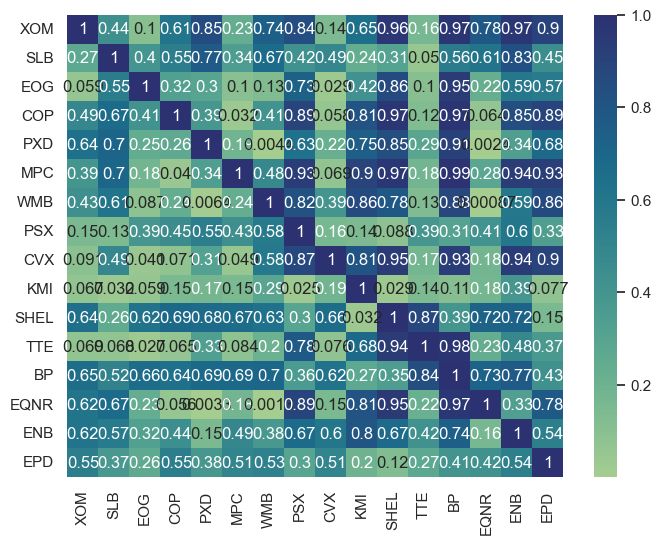

In [8]:
pvalues, stock_pairs = cointegration_test(stock_data, stocks)
from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=100)
sns.heatmap(pvalues, xticklabels = stocks, yticklabels = stocks, cmap = 'crest',  annot = True)

The pairs of stocks having a cointegration are those with a p-value less than the threshold of 0.05.
P-value can be considered as a measure of the strength of cointegration between the two series. A lower p-value indicates a stronger cointegration

In [9]:
print(min(stock_pairs))
cointegrated_stock_pair = {}
cointegrated_stock_pair['first'] = min(stock_pairs)[1][0]
cointegrated_stock_pair['second'] = min(stock_pairs)[1][1]

(0.0008713482465753643, ('WMB', 'EQNR'))


Find the ratio of the average stock prices between the two cointegrated stocks such that the following plot more clearly shows the correlation between the two stock's prices overtime

In [10]:
stock_1_avg_price = stock_data[cointegrated_stock_pair['first']][1]
stock_2_avg_price = stock_data[cointegrated_stock_pair['second']][1]

if stock_1_avg_price > stock_2_avg_price:
    price_ratio = stock_1_avg_price / stock_2_avg_price
else: 
    price_ratio = stock_2_avg_price / stock_1_avg_price

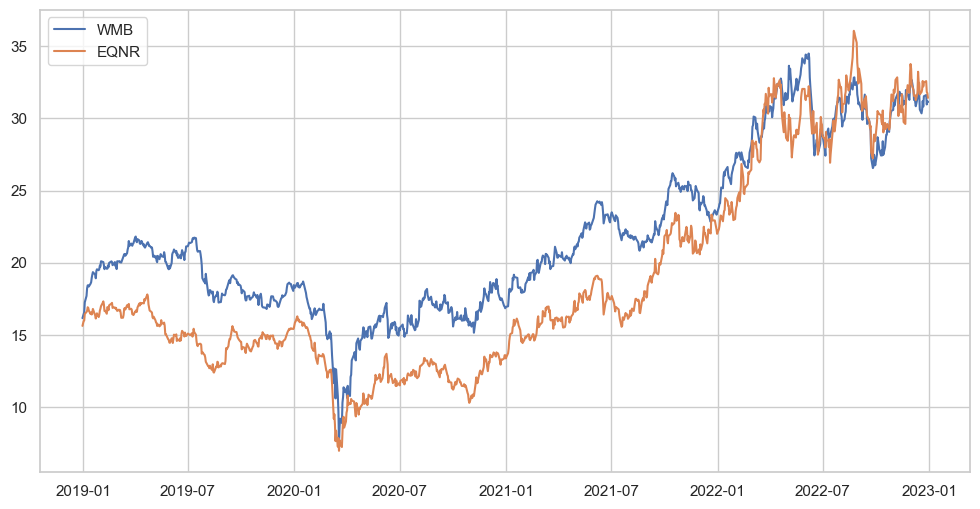

In [11]:
plt.figure(figsize = (12, 6))
plt.plot(stock_data[cointegrated_stock_pair['first']], label = cointegrated_stock_pair['first'])
plt.plot(stock_data[cointegrated_stock_pair['second']]/price_ratio, label = cointegrated_stock_pair['second'])
plt.legend()
plt.show()

### **Testing Data**

The strategy will use a 6 month testing period from January 2023 to June 2023. The spread between the prices of the two stocks will be used to determine points of entry and exit for the pairs trade.

[*********************100%%**********************]  2 of 2 completed

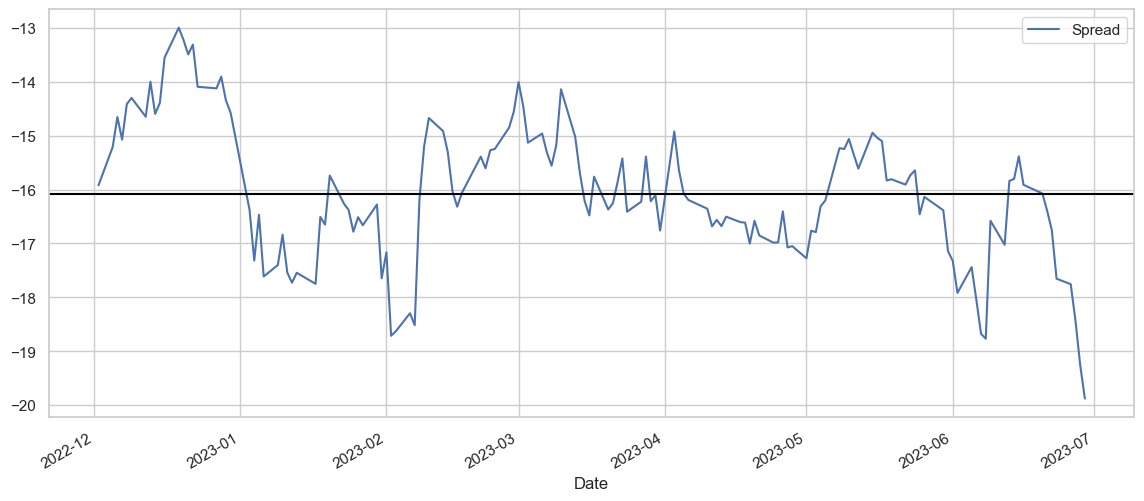

In [13]:

stock_pair_names = list(cointegrated_stock_pair.values())
asset_pairs =  yf.download(stock_pair_names, start="2022-12-02" ,end= "2023-06-30")['Adj Close']

S1=asset_pairs[stock_pair_names[0]]
S2=asset_pairs[stock_pair_names[1]]

S1 = sm.add_constant(S1)
results = sm.OLS(S2, S1).fit()
S1 = S1[stock_pair_names[0]]
b = results.params[stock_pair_names[0]]

spread = S2 - b * S1
spread.plot(figsize=(14, 6))
plt.axhline(spread.mean(), color='black')
plt.legend(['Spread'])

## **Z-Score**

A Z-score is a numerical measurement that describes a value's relationship to the mean of a group of values. Z-score is measured in terms of standard deviations from the mean. Z-scores also make it possible to adapt values from data sets having a very different ranges to make scores that are comparable.
Essentially, z-scores can shrink a large range of values into a much smaller range which is easier to handle.

Zscore.svg

𝒳 = series

μ = series mean

σ = series standard deviation

In [14]:
def zscore(series):
    lookback = 20
    scores = []
    for i in range(lookback, len(series)):
      window = series[i-lookback:i]
      scores.append((series[i]-window.mean())/window.std())
    return pd.Series(scores, index = series.index[lookback:])


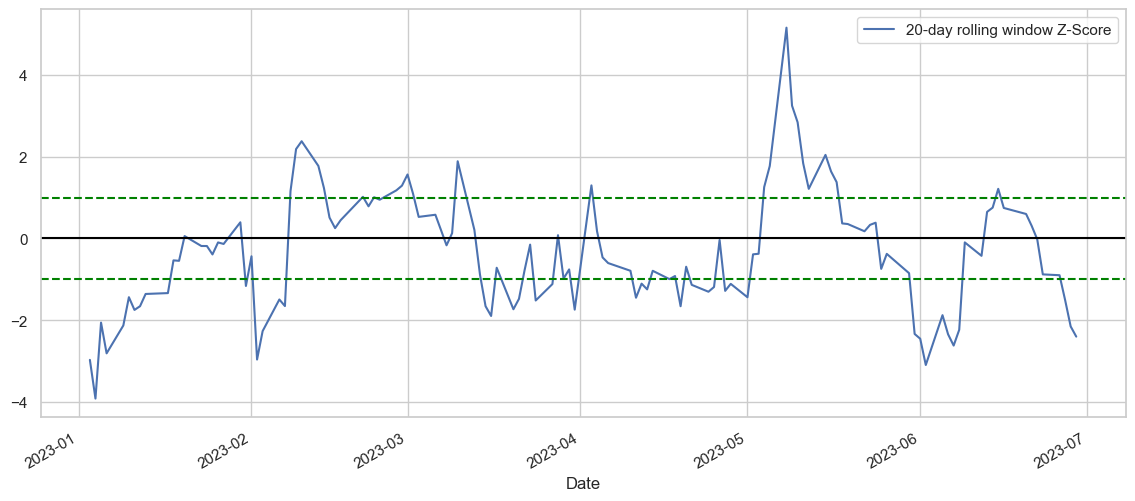

In [15]:
zscore(spread).plot(figsize=(14, 6))
plt.axhline(0.0, color='black')
plt.axhline(1.0, color='green', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['20-day rolling window Z-Score'])

## **Trading Strategy**

Implementation of a simple mean-reversion based strategy. The threshold levels for the Z-score are taken as +1 and -1. Whenever the Z-score value rises above +1, it is expected to fall in the future and a short position is taken on the pair. Similarly, when the Z-score value falls below -1, it is expected to rise in the future and a long position is taken on the pair.


In [17]:
def generate_trade_signals(S1, S2, spread):
  signals = pd.DataFrame()
  signals['price1'] = S1
  signals['price2'] = S2
  signals['spread'] = spread
  signals['zscore'] = zscore(spread)
  signals.dropna(inplace = True)

  # initialize first signal
  signal_list = []
  if signals['zscore'][0] > 1:
    signal = 'new trade +'
    trade_z = signals['zscore'][0]
  elif signals['zscore'][0] < -1:
    signal = 'new trade -'
    trade_z = signals['zscore'][0]   
  else:
    signal = 'no signal'
    trade_z = None 

  signal_list.append(signal)


  new_trade_threshold = 1.25
  stop_loss_threshold = 1.5


  stop_loss_triggered = None

  # add all others signals  
  for z, prev_z in zip(signals['zscore'][1:], signals['zscore'][:-1]):
    # cases where an existing trade is exited:
    if stop_loss_triggered:
      signal = 'no signal'
      if stop_loss_triggered == '+':
        if z < 1:
          stop_loss_triggered = None  
      elif stop_loss_triggered == '-':
        if z > -1:
          stop_loss_triggered = None

    else:
    
      if trade_z:
        if trade_z > new_trade_threshold:
          if z > trade_z + stop_loss_threshold:
            signal = 'stop loss +'
            trade_z = None
            stop_loss_triggered = '+'
          elif prev_z > new_trade_threshold and z < new_trade_threshold:
            signal = 'take profit +'
            trade_z = None
          else:
            signal = 'no signal'

        elif trade_z < -1 * new_trade_threshold:
          if z < trade_z - stop_loss_threshold:
            signal = 'stop loss -'
            trade_z = None
            stop_loss_triggered = '-'
          elif prev_z < -1 * new_trade_threshold and z > -1 * new_trade_threshold:
            signal = 'take profit -'
            trade_z = None
          else:
            signal = 'no signal'


      # cases where a new trade is triggered 
      else:    
        if z > new_trade_threshold:
          signal = 'new trade +'
          trade_z = z
        elif z < -1 * new_trade_threshold:
          signal = 'new trade -'
          trade_z = z
        elif new_trade_threshold > z > -1*new_trade_threshold and new_trade_threshold > prev_z > -1*new_trade_threshold:
          signal = 'no signal'
        else:
          print('OTHER CASE:', z, prev_z)
          signal = 'no signal'


    signal_list.append(signal)

  signals['signal'] = signal_list
  

  return signals



In [18]:
trade_signals = generate_trade_signals(S1, S2, spread)

print(trade_signals[40:60])

OTHER CASE: 0.18160409619974277 1.2998297724937378
               price1     price2     spread    zscore         signal
Date                                                                
2023-03-02  28.789093  28.508108 -14.452943  1.090475  take profit +
2023-03-03  29.309605  28.608908 -15.128886  0.528557      no signal
2023-03-06  29.054081  28.398142 -14.958342  0.581044      no signal
2023-03-07  28.741774  27.582579 -15.307859  0.207777      no signal
2023-03-08  28.741774  27.335159 -15.555278 -0.167205      no signal
2023-03-09  28.287506  27.041924 -15.170625  0.129594      no signal
2023-03-10  27.766760  27.298506 -14.136950  1.890385    new trade +
2023-03-13  27.872446  26.574577 -15.018590  0.207758  take profit +
2023-03-14  28.103035  26.244684 -15.692584 -0.883302      no signal
2023-03-15  27.651468  25.053411 -16.209998 -1.658018    new trade -
2023-03-16  27.689898  24.842649 -16.478107 -1.897605      no signal
2023-03-17  27.190287  24.815157 -15.760046 -0.71690

### **Visualising the positions**

**1) Trades on the pair**

In [19]:
def plot_pair_trades(trade_signals):
  fig = plt.figure(figsize=(14, 6))
  bx = fig.add_subplot(111)
  series = bx.plot(trade_signals['zscore'], c='#4abdac')
  new_trade_long = bx.plot(trade_signals['zscore'][trade_signals['signal'] == 'new trade -'], lw = 0, marker = '^', markersize = 8, c = 'g', alpha = 0.9)
  take_profit_long = bx.plot(trade_signals['zscore'][trade_signals['signal'] == 'take profit -'], lw = 0, marker = 'v', markersize = 8, c = 'y', alpha = 0.9)
  stop_loss_long = bx.plot(trade_signals['zscore'][trade_signals['signal'] == 'stop loss -'], lw = 0, marker = 'v', markersize = 8, c = 'k', alpha = 0.9)
  
  new_trade_short = bx.plot(trade_signals['zscore'][trade_signals['signal'] == 'new trade +'], lw = 0, marker = 'v', markersize = 8, c = 'r', alpha = 0.9)
  take_profit_short = bx.plot(trade_signals['zscore'][trade_signals['signal'] == 'take profit +'], lw = 0, marker = '^', markersize = 8, c = 'y', alpha = 0.9)
  stop_loss_short = bx.plot(trade_signals['zscore'][trade_signals['signal'] == 'stop loss +'], lw = 0, marker = '^', markersize = 8, c = 'k', alpha = 0.9)

  
  stock1 = stock_pair_names[0]
  stock2 = stock_pair_names[1]
  plt.title(f'{stock2} / {stock1}')
  plt.legend(['Z-Score', 'New Trade Long', 'Take Profit Long', 'Stop Loss Long', 'New Trade Short', 'Take Profit Short', 'Stop Loss Short'])

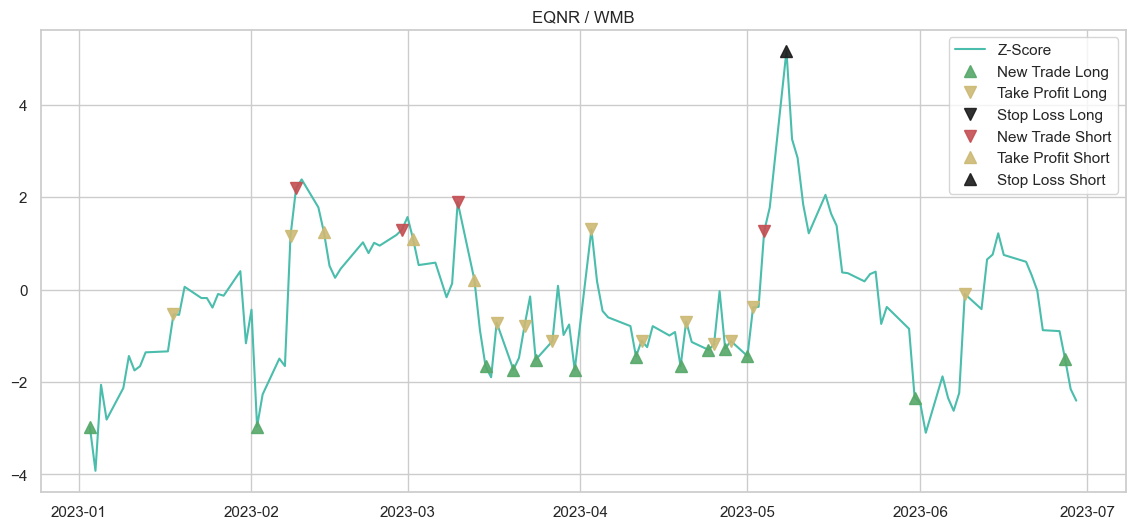

In [20]:
plot_pair_trades(trade_signals)

*   **Long position => buy PNC Financial Services and sell Bank of America**
*   **Short position => sell PNC Financial Services and buy Bank of America**

In [22]:
# TODO: can make sure only whole shares are purchased instead of fractional shares
    # this would make use of cost_1 and cost_2, which are not being used now
    # could also implement 'value' to see unrealized gain day-by-day

def calculate_pnl(signals):
    capital = 100000
    num_shares_1, num_shares_2 = 0, 0

    capital_list = []
    value_list = []
    for i in range(len(signals)):
        signal = signals['signal'][i]
        price_1, price_2 = signals['price1'][i], signals['price2'][i]

        value = capital + num_shares_1 * price_1 + num_shares_2 * price_2
        #print('capital: ', capital)
        if signal != 'no signal':
            if 'new trade' in signal: # buying shares
                if '+' in signal: # short on first stock
                    num_shares_1 = capital / 2 / price_1
                    cost_1 = num_shares_1 * price_1 
                    num_shares_2 = capital / 2 / price_2
                    proceeds_2 = num_shares_2 * price_2 # because shorting 1st stock, proceeds are from initial sale
                elif '-' in signal:
                    pass
                    num_shares_1 = capital / 2 / price_1
                    proceeds_1 = num_shares_1 * price_1
                    num_shares_2 = capital / 2 / price_2
                    cost_2 = num_shares_2 * price_2
                capital = 0
            elif 'take profit' in signal or 'stop loss' in signal: # selling shares
                if '+' in signal:
                    proceeds_1 = num_shares_1 * price_1
                    cost_2 = num_shares_2 * price_2
                elif '-' in signal:
                    cost_1 = num_shares_1 * price_1
                    proceeds_2 = num_shares_2 * price_2
                capital = proceeds_1 + proceeds_2 

        capital_list.append(capital)
    signals['capital'] = capital_list



In [23]:
calculate_pnl(trade_signals)
pd.set_option('expand_frame_repr', False)
print(trade_signals[-50:])

               price1     price2     spread    zscore         signal        capital
Date                                                                               
2023-04-19  28.900490  26.125559 -17.001726 -1.658736    new trade -       0.000000
2023-04-20  28.660294  26.189705 -16.579143 -0.691911  take profit -  109262.065680
2023-04-21  28.756372  26.061413 -16.850810 -1.135469      no signal  109262.065680
2023-04-24  29.140688  26.501268 -16.984457 -1.304127    new trade -       0.000000
2023-04-25  28.756372  25.933121 -16.979102 -1.188166  take profit -  108090.857835
2023-04-26  28.285587  25.804831 -16.404855 -0.036640      no signal  108090.857835
2023-04-27  28.641077  25.667377 -17.072794 -1.283021    new trade -       0.000000
2023-04-28  29.073433  26.336321 -17.049041 -1.111483  take profit -  109499.390253
2023-05-01  29.169512  26.253849 -17.274889 -1.439310    new trade -       0.000000
2023-05-02  28.151075  25.245846 -16.763112 -0.388435  take profit -  107397

**2) Trades on First Stock**

In [24]:
def plot_trades_1(signals):
  fig = plt.figure(figsize=(14,6))
  bx = fig.add_subplot(111)
  l1 = bx.plot(signals['price1'], c='#4abdac')
  u1 = bx.plot(signals['price1'][signals['position1'] == 1], lw=0, marker='^', markersize=7, c='g',alpha=0.9)
  u2, = bx.plot(signals['price1'][signals['position1'] == -1], lw=0, marker='v', markersize=7, c='r',alpha=0.9)
  plt.title(stock_pair_names[0])
  plt.legend(['Price', 'Long', 'Short'])

KeyError: 'position1'

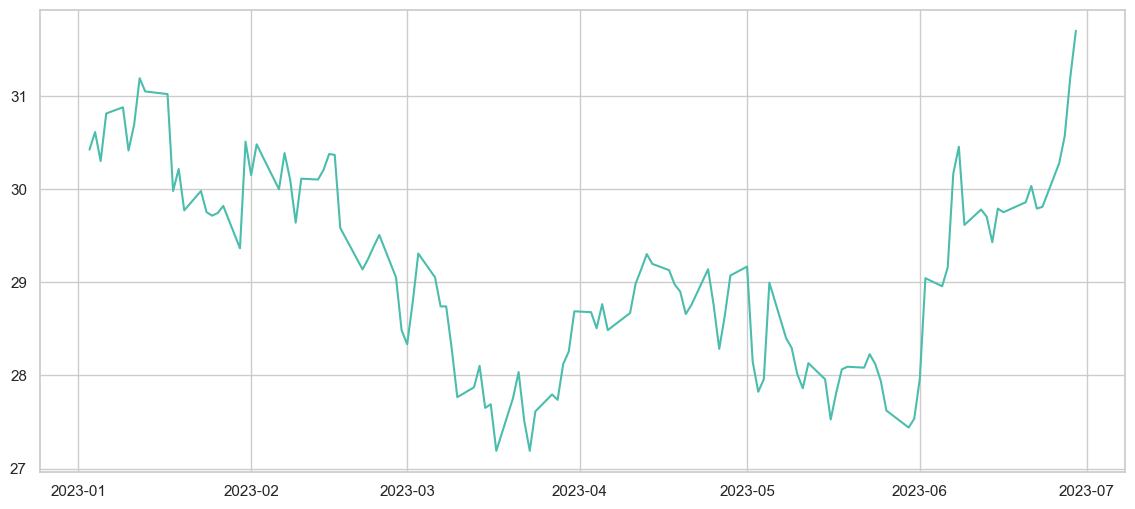

In [25]:
plot_trades_1(trade_signals)

**3) Trades on Second Stock**

In [23]:
def plot_trades_2(signals):
  fig=plt.figure(figsize=(14,6))
  bx = fig.add_subplot(111)
  l1 = bx.plot(signals['price2'], c='#4abdac')
  u1 = bx.plot(signals['price2'][signals['position2'] == 1], lw=0, marker='^', markersize=7, c='g',alpha=0.9)
  u2 = bx.plot(signals['price2'][signals['position2'] == -1], lw=0, marker='v', markersize=7, c='r',alpha=0.9)
  plt.title(stock_pair_names[1])
  plt.legend(['Price', 'Long', 'Short'])

In [ ]:
plot_trades_2(trade_signals)

## **Portfolio Performance**

### **PnL Calculation**

In [85]:
def pnl_calculation(signals):

  initial_capital = 50000

  # Shares to buy for each stock
  shares1 = initial_capital// (signals['price1'][0])
  shares2 = initial_capital// (signals['price2'][0])

  #PnL for stock 1
  portfolio = pd.DataFrame()
  portfolio['holdings1'] = signals['position1'].cumsum() * signals['price1'] * shares1
  portfolio['cash1'] = initial_capital - (signals['position1'] * signals['price1'] * shares1).cumsum()
  portfolio['total1'] = portfolio['holdings1'] + portfolio['cash1']
  portfolio['return1'] = portfolio['total1'].pct_change()

  # PnL for stock 2
  portfolio['holdings2'] = signals['position2'].cumsum() * signals['price2'] * shares2
  portfolio['cash2'] = initial_capital - (signals['position2'] * signals['price2'] * shares2).cumsum()
  portfolio['total2'] = portfolio['holdings2'] + portfolio['cash2']
  portfolio['return2'] = portfolio['total2'].pct_change()

  # Total PnL
  portfolio['total'] = portfolio['total1'] + portfolio['total2']
  portfolio = portfolio.dropna()

  return portfolio


In [86]:
portfolio = pnl_calculation(trade_signals)
portfolio.head()

,holdings1,cash1,total1,return1,holdings2,cash2,total2,return2,total
Date,,,,,,,,,
2023-01-24,0.0,50000.0,50000.0,0.0,0.0,50000.0,50000.0,0.0,100000.0
2023-01-25,0.0,50000.0,50000.0,0.0,0.0,50000.0,50000.0,0.0,100000.0
2023-01-26,0.0,50000.0,50000.0,0.0,0.0,50000.0,50000.0,0.0,100000.0
2023-01-27,0.0,50000.0,50000.0,0.0,0.0,50000.0,50000.0,0.0,100000.0
2023-01-30,0.0,50000.0,50000.0,0.0,0.0,50000.0,50000.0,0.0,100000.0


In [87]:
def plot_portfolio_value(portfolio):

  fig = plt.figure(figsize=(14,6),)
  ax = fig.add_subplot(111)
  l1, = ax.plot(portfolio['total'], c='g')
  ax.set_ylabel('Asset Value')
  ax.yaxis.labelpad=15
  ax.set_xlabel('Date')
  ax.xaxis.labelpad=15
  plt.title('Portfolio Performance PnL')
  plt.legend(['Total Portfolio Value'])

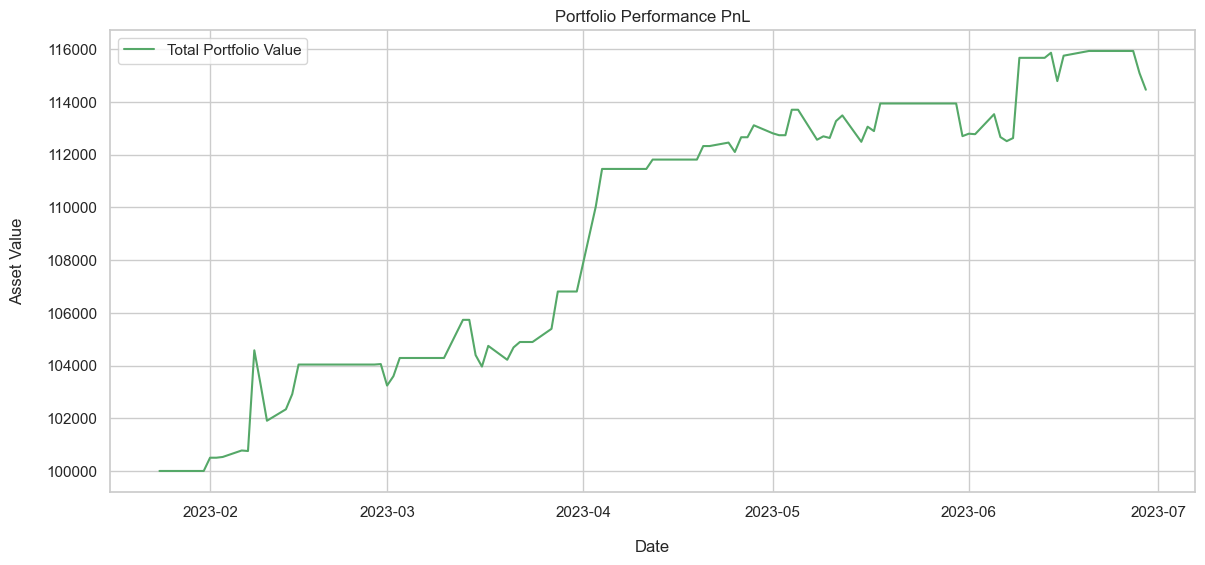

In [88]:
plot_portfolio_value(portfolio)

## **Portfolio Returns**

In [89]:
def calculate_cagr(portfolio):

  final_portfolio = portfolio['total'].iloc[-1]
  initial_portfolio = portfolio['total'].iloc[0]
  delta = len(portfolio.index)
  print('Number of trading days = ', delta)
  YEAR_DAYS = 252
  returns = (final_portfolio/initial_portfolio) ** (YEAR_DAYS/delta) - 1
  return returns

In [90]:
print('CAGR = {:.3f}%' .format(calculate_cagr(portfolio) * 100))

Number of trading days =  109
CAGR = 36.645%


Returns are also compared to a benchmark to assess the performance of the trading strategy in comparison to the overall market. For the purpose of this strategy, the KBW Nasdaq Bank Index is taken as a benchmark.

[*********************100%%**********************]  1 of 1 completed


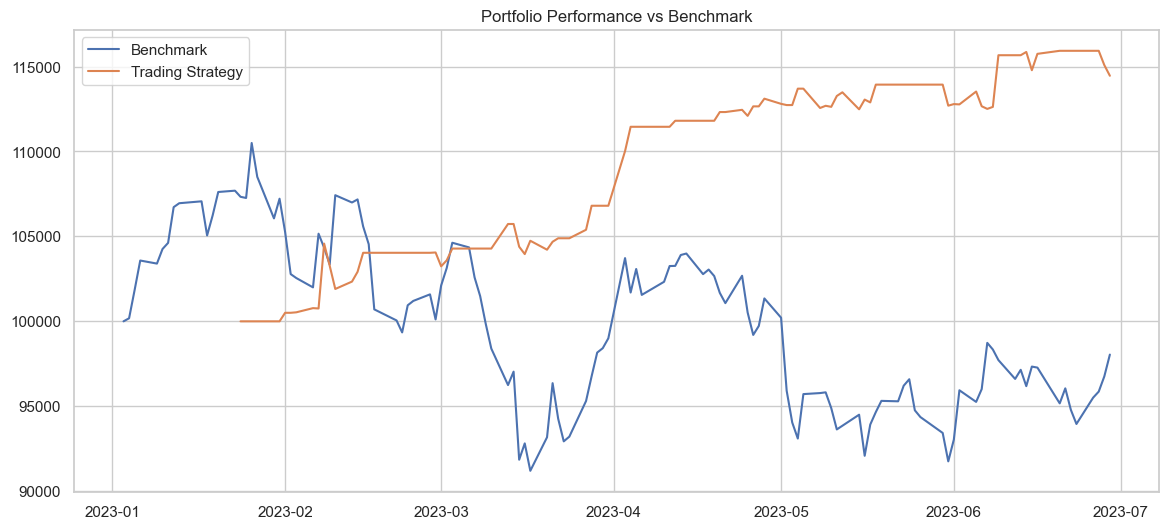

In [91]:
benchmark_name = 'VDE'
index = yf.download(benchmark_name, start = '2023-01-01', end = '2023-06-30')['Adj Close']
shares = 100000/index[0]

plt.figure(figsize = (14, 6))
plt.plot(index*shares)
plt.plot(portfolio['total'])
plt.title('Portfolio Performance vs Benchmark')
plt.legend(['Benchmark', 'Trading Strategy'])

In [92]:
cagr_index = (index.iloc[-1] / index[0])**(252/len(index)) - 1
print("CAGR of " + benchmark_name + ":", np.round(cagr_index*100, 3), "%")
cagr_portfolio = (portfolio['total'][-1] / portfolio['total'][0]) ** (252/len(portfolio)) - 1
print("CAGR of trading strategy:", np.round(cagr_portfolio*100, 3), "%")

CAGR of VDE: -3.97 %
CAGR of trading strategy: 36.645 %
